In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# unscaled, log-normalized counts, with conditions subsampled to the same number of cells 
# and 2000 highly variable genes calculated jointly across all perturbation conditions, including control, using scanpy28 with default parameters (Supplementary Methods)

In [3]:
from anndata import read_h5ad
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import scanpy as sc
import seaborn as sns
import string
import sys
from sklearn.linear_model import LinearRegression
np.random.seed(42)

In [4]:
reference = 0
group_by = "dose_value"

In [5]:
ram = pd.read_csv("../evaluation_results/job_memory_usage.csv")
ram.loc[ram["k"] == 0, "k"] = ram.loc[ram["k"] == 0, "n_obs"] 
ram = ram.astype(float)

In [6]:
assert not ram.set_index(["k", "n_obs", "n_var"]).index.has_duplicates

In [7]:
df = pd.concat([pd.read_csv(f"../evaluation_results/runtime_memory_log_{n_obs}.txt", delimiter=",") for n_obs in [500, 1000, 2000, 5000, 10000, 20000, 50000]])

In [8]:
df_filtered = df[~(df.eq(df.columns).all(axis=1))]
df_filtered.loc[df_filtered["k"].isna(), "k"] = df_filtered.loc[df_filtered["k"].isna(), "n_obs"] 
df_filtered = df_filtered.astype(float)

In [9]:
assert not df_filtered.set_index(["k", "n_obs", "n_var"]).index.has_duplicates

In [10]:
conc = pd.concat([ram.set_index(["k", "n_obs", "n_var"]), df_filtered.set_index(["k", "n_obs", "n_var"])], axis=1).reset_index()

In [11]:
conc = conc[conc["k"] < conc["n_obs"]]

In [12]:
conc["upper_lim_edges"] = conc["k"] * conc["n_obs"]

In [13]:
conc["t_total"] = conc["t_NN [s]"] + conc["t_matching [s]"]

In [14]:
conc.rename({"n_obs": "$n_{obs}$", "n_var": "$n_{var}$", "k": "$k$"}, axis=1, inplace=True)

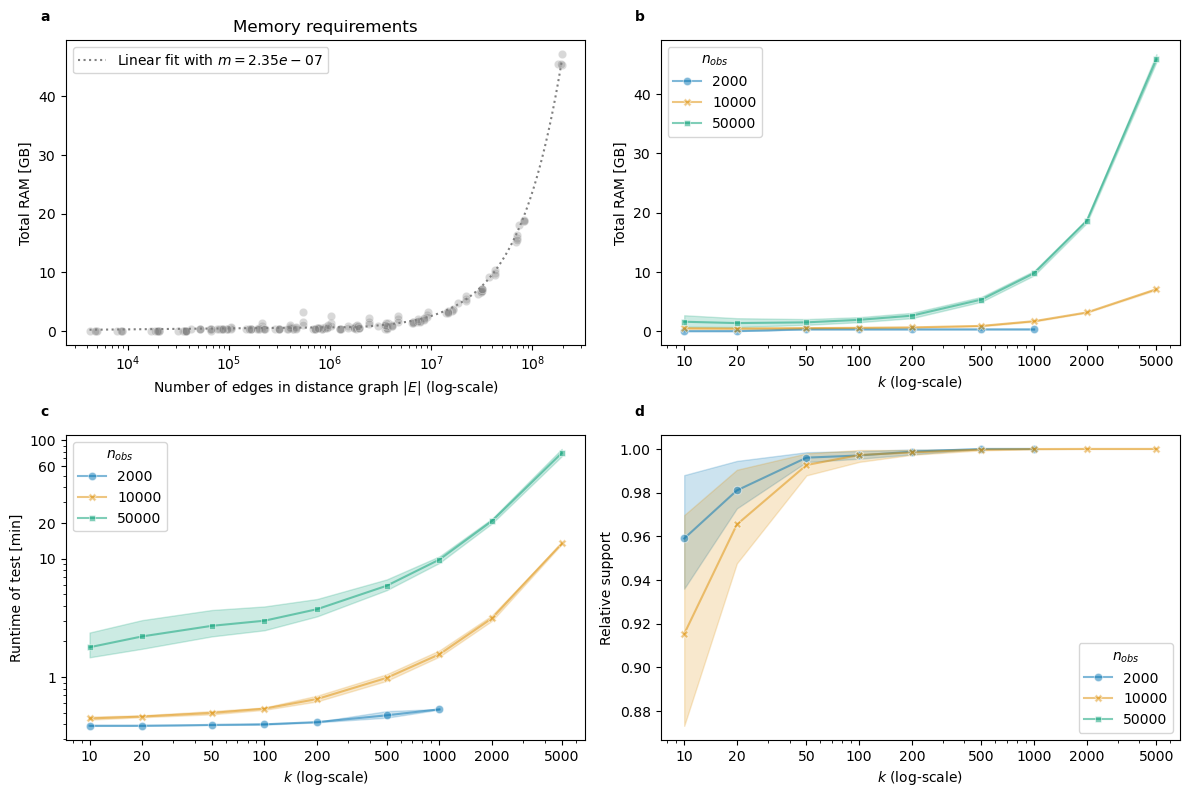

In [17]:
f, axs = plt.subplots(2, 2, figsize=(12, 8))
#f.set_size_inches(12, 8)  
plt.subplots_adjust(top=0.75)
ax0 = axs[0, 0]
ax1 = axs[0, 1]
ax2 = axs[1, 0]
ax3 = axs[1, 1]

X = conc.loc[(conc["$k$"] > 0) & (conc["n_edges"].notna()), "n_edges"].values.reshape(-1, 1)
y = conc.loc[(conc["$k$"] > 0) & (conc["n_edges"].notna()), "total_ram_gb"].values.reshape(-1, 1)
lr = LinearRegression().fit(X, y)

conc[["$k$", "$n_{obs}$", "$n_{var}$"]] = conc[["$k$", "$n_{obs}$", "$n_{var}$"]].astype(int)
sns.scatterplot(conc, ax=ax0, x="n_edges", y="total_ram_gb", legend=False, color="gray", alpha=0.3)

X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = lr.predict(X_fit)
ax0.plot(X_fit, y_fit, color="grey", label=f"Linear fit with $m={lr.coef_.item():.2e}$", ls="dotted")
ax0.legend()
ax0.set_ylabel("Total RAM [GB]")
ax0.set_xlabel("Number of edges in distance graph $|E|$ (log-scale)")
ax0.set_xscale("log")
ax0.set_title("Memory requirements")

conc_subset = conc[conc['$n_{obs}$'].isin([2000, 10000, 50000])]
sns.lineplot(conc_subset, ax=ax1, x='$k$', y="total_ram_gb", hue="$n_{obs}$", style="$n_{obs}$", dashes=False, markers=True, palette=sns.color_palette("colorblind", 3), alpha=0.5, legend=True)
ax1.set_xscale("log")

ax1.set_xticks(sorted(conc_subset['$k$'].unique()))  # Set tick positions
ax1.set_xticklabels(sorted(conc_subset['$k$'].unique()))  # Set label

ax1.set_ylabel("Total RAM [GB]")
ax1.set_xlabel("$k$ (log-scale)")


conc_subset = conc_subset[conc_subset['$n_{obs}$'] != conc_subset['$k$'] ]
conc_subset["Runtime of test [min]"] = conc_subset["t_total"] / (60)
sns.lineplot(conc_subset, ax=ax2, x='$k$', y="Runtime of test [min]", hue="$n_{obs}$", style="$n_{obs}$", dashes=False, markers=True, palette=sns.color_palette("colorblind", 3), alpha=0.5, legend=True)
ax2.set_xscale("log")
ax2.set_yscale("log")

ax2.set_xticks(sorted(conc_subset['$k$'].unique()))  # Set tick positions
ax2.set_xticklabels(sorted(conc_subset['$k$'].unique()))  # Set label

ax2.set_yticks([1, 10, 20, 60, 100])  # Set tick positions
ax2.set_yticklabels([1, 10, 20, 60, 100])  # Set labels

ax2.set_xlabel("$k$ (log-scale)")

sns.lineplot(conc_subset, ax=ax3, x='$k$', y="s", hue="$n_{obs}$", style="$n_{obs}$", dashes=False, markers=True, palette=sns.color_palette("colorblind", 3), alpha=0.5, legend=True)
ax3.set_xscale("log")

ax3.set_xticks(sorted(conc_subset['$k$'].unique()))  # Set tick positions
ax3.set_xticklabels(sorted(conc_subset['$k$'].unique()))  # Set label
ax3.set_xlabel("$k$ (log-scale)")
ax3.set_ylabel("Relative support")


labels = ["a", "b", "c", "d"]

for i, label in enumerate(labels):
    axs[i // 2, i % 2].text(
        -0.05, 1.1,  # Position (normalized figure coordinates)
        labels[i],   # Corresponding letter
        transform=axs[i // 2, i % 2].transAxes,  # Relative to subplot
        fontsize=10, fontweight='bold', va='top', ha='left'
    )
plt.tight_layout()  
#plt.savefig("../plots/fig2/runtime_memory.pdf", bbox_inches="tight")

In [16]:
conc

,$k$,$n_{obs}$,$n_{var}$,total_ram_gb,n_edges,t_NN [s],t_matching [s],Peak Memory [MB] kNN,Peak Memory [MB] matching,s,upper_lim_edges,t_total
28,1000,10000,1000,1.7,7775674.0,72.766344,16.655362,846.84,866.01,1.0000,10000000.0,89.421706
29,1000,10000,10,1.6,7197133.0,66.291435,24.296906,875.02,868.22,1.0000,10000000.0,90.588341
30,1000,10000,2000,1.8,7786934.0,86.846760,17.712134,1024.43,975.68,0.9998,10000000.0,104.558894
31,1000,10000,500,1.6,7715383.0,71.268563,17.935203,804.51,864.86,1.0000,10000000.0,89.203766
32,1000,20000,1000,3.6,16285894.0,133.234451,56.710202,992.25,989.72,NaN,20000000.0,189.944653
...,...,...,...,...,...,...,...,...,...,...,...,...
235,50,5000,500,0.3,223057.0,24.421864,0.878766,190.05,196.79,NaN,250000.0,25.300630
236,50,500,1000,0.0,19979.0,23.370863,0.018630,159.83,161.71,NaN,25000.0,23.389493
237,50,500,10,0.0,18664.0,23.428194,0.021490,157.71,161.45,NaN,25000.0,23.449684
238,50,500,2000,0.0,19855.0,23.378839,0.018342,154.60,155.74,NaN,25000.0,23.397181
